In [19]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
Figsize = (10,10)
Image_path = 'assets/Test/marker_cut_rgb_512.png'
Threshold_binarization = 205
Canny_threshold_lower = 150
Canny_threshold_upper = 200
Hough_theta_step = np.pi / 180
Hough_rho_step = 1
Hough_threshold = 30

In [24]:
def url_to_image(url):
    print('downloading {}'.format(url))
    return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2GRAY)

def _plot(img):
    plt.figure(figsize=Figsize)
    plt.imshow(img, cmap=plt.cm.gray)

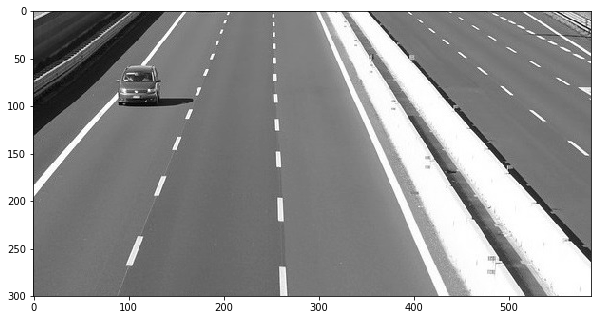

In [25]:
img = cv2.imread(Image_path, cv2.IMREAD_GRAYSCALE)
_plot(img)

In [26]:
def _create_gaussian(size, sigma):
    mid = size // 2
    kernel = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            x,y = i - mid, j - mid
            kernel[i,j] = np.exp(-(x**2+y**2)/(2*sigma**2)) / (2*np.pi * sigma**2)

    return kernel

def _filter(image, kernel):
    ksize = kernel.shape[0]
    pad = ksize // 2
    image_padded = np.zeros((image.shape[0] + 2*pad, image.shape[1] + 2*pad))
    image_padded[pad:-pad, pad:-pad] = image
    out = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x,y = i + pad,j + pad
            out[i, j] = (kernel * image_padded[i:i + ksize, j:j + ksize]).sum()
    return out

def gaussian_blur(img, kernel_sz, sigma):
    kernel = _create_gaussian(kernel_sz, sigma)
    return _filter(img, kernel)

In [27]:
def threshold(img, level, upper_bound):
    bin_img = img.copy()
    h,w = bin_img.shape
    for i in range(h):
        for j in range(w):
            bin_img[i,j] = 0 if img[i,j] < level else upper_bound
    return bin_img

In [28]:
from scipy import ndimage

def intensity_gradient(img):
    # Sobel Kernel - https://en.wikipedia.org/wiki/Sobel_operator
    Kx = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], 
                   [0, 0, 0], 
                   [-1, -2, -1]])

    Gx = _filter(img, Kx)
    Gy = _filter(img, Ky)
    
    G = np.hypot(Gx, Gy)
    Theta = np.arctan2(Gy, Gx)
    return (G, Theta)

In [29]:
def round_angle(angle):
    # The source of function's skeleton, which was refactored
    # http://justin-liang.com/tutorials/canny/#grayscale
    angle = np.rad2deg(angle) % 180
    if (angle < 22.5 or 157.5 <= angle):
        angle = 0
    elif (22.5 <= angle < 67.5):
        angle = 45
    elif (67.5 <= angle < 112.5):
        angle = 90
    elif (112.5 <= angle < 157.5):
        angle = 135
    return angle

def suppression(img, Theta):
    # The source of function's skeleton, which was refactored
    # http://justin-liang.com/tutorials/canny/#grayscale
    Z = np.zeros(img.shape)
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            angle = round_angle(Theta[i, j])
            if angle == 0:
                if (img[i, j] > img[i, j - 1]) and (img[i, j] > img[i, j + 1]):
                    Z[i,j] = img[i,j]
            elif angle == 90:
                if (img[i, j] > img[i - 1, j]) and (img[i, j] > img[i + 1, j]):
                    Z[i,j] = img[i,j]
            elif angle == 135:
                if (img[i, j] > img[i - 1, j - 1]) and (img[i, j] > img[i + 1, j + 1]):
                    Z[i,j] = img[i,j]
            elif angle == 45:
                if (img[i, j] > img[i - 1, j + 1]) and (img[i, j] > img[i + 1, j - 1]):
                    Z[i,j] = img[i,j]
    return Z

In [30]:
WEAK_PIXEL = 50
STRONG_PIXEL = 255
    
def double_threshold(img, th1, th2):
    img_th = np.zeros_like(img)
    img_th[np.where(img > th2)] = STRONG_PIXEL
    img_th[np.where((img >= th1) & (img <= th2))] = WEAK_PIXEL

    return img_th

def get_neighbors(img, i, j):
    neighbors = []
    neighbors.append(img[i+1,j])
    neighbors.append(img[i-1,j])
    neighbors.append(img[i,j+1])
    neighbors.append(img[i,j-1])
    
    neighbors.append(img[i+1,j+1])
    neighbors.append(img[i-1,j-1])
    neighbors.append(img[i-1,j+1])
    neighbors.append(img[i+1,j-1])
    
    return np.array(neighbors, dtype=np.int)

def edge_tracking(img):
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            if img[i, j] == WEAK_PIXEL:
                neighbors = get_neighbors(img, i, j)
                has_strong_neighbor = (sum(neighbors == STRONG_PIXEL) != 0)
                img[i, j] = STRONG_PIXEL if has_strong_neighbor else 0
    return img

In [31]:
def Canny(img, th1, th2, sigma=3, kernel_size=31):
    im = img.astype('float').copy()
    im = gaussian_blur(im, kernel_size, sigma)
    im, Theta = intensity_gradient(im)    
    im = suppression(im, Theta)
    im = double_threshold(im, th1, th2)
    im = edge_tracking(im)
    return im.astype('uint8')

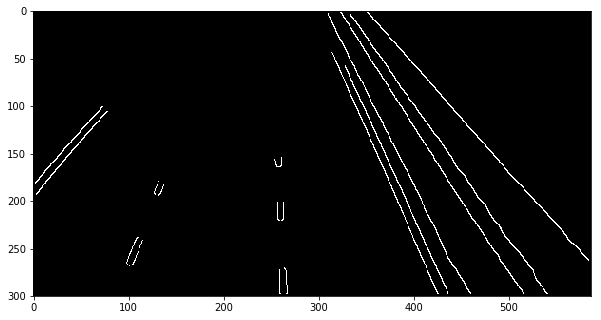

In [32]:
# %%time
PIXEL_MAX = 255

bin_img = threshold(img, Threshold_binarization, PIXEL_MAX)
edges = Canny(bin_img, Canny_threshold_lower, Canny_threshold_upper)
_plot(edges)

## OpenCV

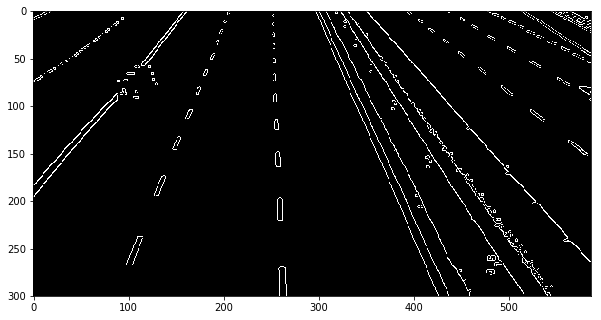

In [42]:
# %%time

ret_cv,bin_img_cv = cv2.threshold(img, Threshold_binarization, PIXEL_MAX, cv2.THRESH_BINARY)
# edges_cv = cv2.Canny(bin_img, Canny_threshold_lower, Canny_threshold_upper)
edges = cv2.Canny(bin_img, Canny_threshold_lower, Canny_threshold_upper)
_plot(edges)

## OpenCV HoughLines

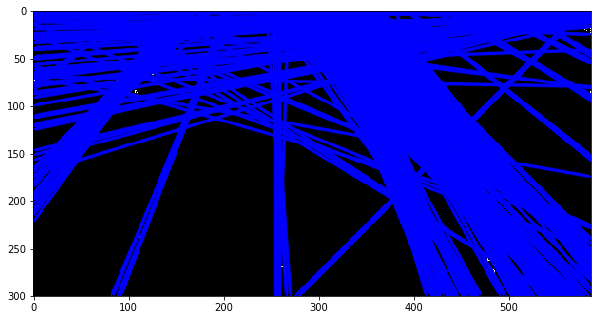

In [43]:
dst = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(edges, rho=Hough_rho_step, theta=Hough_theta_step, threshold=Hough_threshold)
if lines is not None:
    for i in range(len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(dst, pt1, pt2, (0,0,255), 2, cv2.LINE_AA)
_plot(dst)

## Own HoughLines implementation.

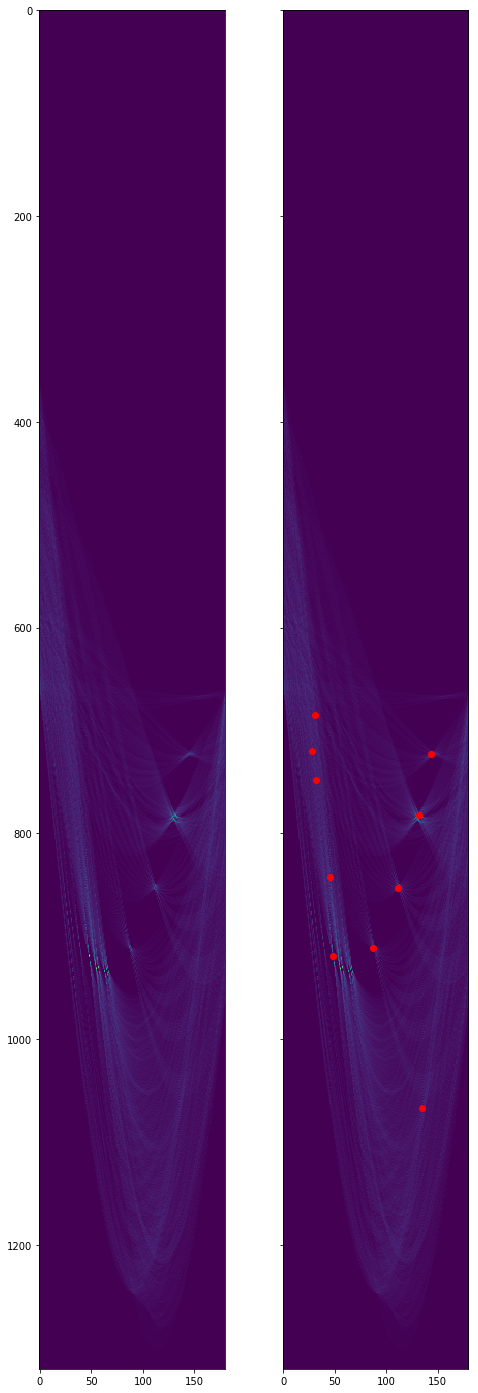

In [44]:
# %%time
from skimage.feature import peak_local_max
from pylab import *

def get_lines(acc, thetas, rhos, threshold, min_distance):
    acc = np.where(acc>=threshold, acc, 0)
    lines_idx = peak_local_max(acc, min_distance=min_distance)
    sorted_idx = sorted(lines_idx, key=lambda x: acc[x[0]][x[1]], reverse=True)
    lines = []
    for ri,ti in sorted_idx:
        t = thetas[ti]
        r = rhos[ri]
        lines.append((t,r))
    return lines, sorted_idx


def hough_line(img, threshold, min_distance=20, theha_step=np.pi/180, rho_step=1, draw=False):
    theha_step_deg = np.rad2deg(theha_step)
    thetas = np.deg2rad(np.arange(-90.0, 90.0, step=theha_step_deg))
    width, height = img.shape
    max_r = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.arange(-max_r, max_r + 1, step=rho_step)

    acc = np.zeros((len(rhos), len(thetas)), dtype=np.uint8)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(len(thetas)):
            # Calculate rho. diag_len is added for a positive index
            t = thetas[t_idx]
            rho = int(round(x * np.cos(t) + y * np.sin(t))) + max_r
            acc[rho, t_idx] += 1

    lines,idx = get_lines(acc, thetas, rhos, threshold,min_distance)
    if draw:
        x,y = [t for r,t in idx], [r for r,t in idx]
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,25))
        ax1.imshow(acc)
        ax2.imshow(acc)
        ax2.plot(x,y, 'ro')
        ax2.autoscale(False)
        
    return lines

lines = hough_line(edges, threshold=Hough_threshold, theha_step=Hough_theta_step,
                   rho_step=Hough_rho_step, min_distance=20, draw=True)

## Plotting out Results

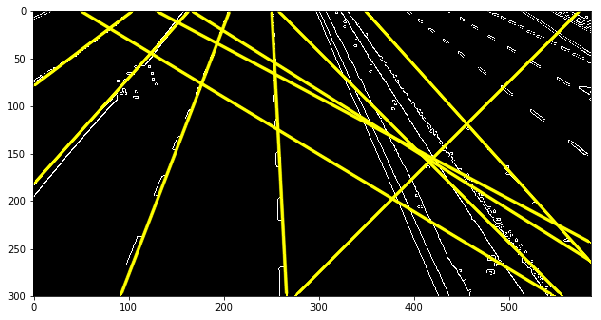

In [45]:
def plot_lines(img, lines, N=0):
    if lines is None: return
    dst = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    size = len(lines) if N == 0 else min(N, len(lines))
    for i in range(size):
        rho = lines[i][1]
        theta = lines[i][0]
            
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            
        cv2.line(dst, pt1, pt2, (255,255,0), 2, cv2.LINE_AA)
        
    _plot(dst)
    
plot_lines(edges, lines)

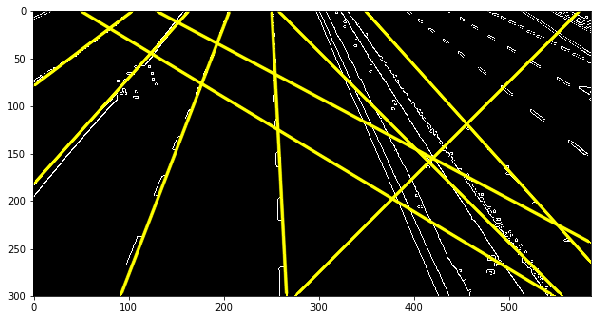

In [47]:
# top 2 lines
plot_lines(edges, lines, N=9)

## 6. Details of Selected Lines

In [48]:
print ('\tTheta, R')
for i in range(len(lines)):
    print('{}) {}'.format(i + 1, lines[i]))

	Theta, R
1) (-0.7330382858376184, 259)
2) (0.7330382858376184, 122)
3) (-0.05235987755982989, 251)
4) (0.3665191429188092, 193)
5) (-0.7853981633974483, 182)
6) (0.9250245035569946, 63)
7) (0.7853981633974483, 407)
8) (-1.0297442586766545, 25)
9) (-1.0821041362364843, 60)
10) (-1.0122909661567112, 88)


In [49]:
for i in range(len(lines)):
    t,r = lines[i]
    k = - np.cos(t) / np.sin(t)
    b = r / np.sin(t)
    print('{}) y = {}x + {}'.format(i + 1, round(k,2), round(b, 2)))

1) y = 1.11x + -387.07
2) y = -1.11x + 182.33
3) y = 19.08x + -4795.94
4) y = -2.61x + 538.55
5) y = 1.0x + -257.39
6) y = -0.75x + 78.88
7) y = -1.0x + 575.58
8) y = 0.6x + -29.17
9) y = 0.53x + -67.95
10) y = 0.62x + -103.77
